In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
order_products_train = pd.read_csv('order_products__train.csv')
order_products_prior = pd.read_csv('order_products__prior.csv')
orders = pd.read_csv('orders.csv')

products = pd.read_csv('products.csv')
aisles = pd.read_csv('aisles.csv')
departments = pd.read_csv('departments.csv')

In [3]:
print("The order_products_train size is : ", order_products_train.shape)
print("The order_products_prior size is : ", order_products_prior.shape)

The order_products_train size is :  (1384617, 4)
The order_products_prior size is :  (32434489, 4)


   user_id  order_hour_min  order_hour_mean  order_hour_max
0        1               7           10.091              16
1        2               9           10.600              15
2        3              14           16.308              19
3        4              11           12.500              15
4        5              11           15.000              18
5        6              16           17.000              18
6        7               7           13.476              20
7        8               0            5.500              14
8        9              10           13.250              17
9       10              14           17.000              20


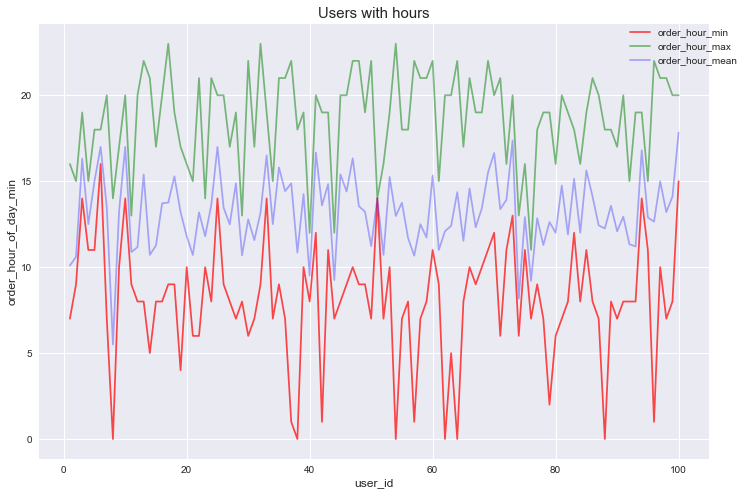

In [4]:
import pylab as pl

grouped = orders.groupby("user_id")["order_hour_of_day"].aggregate({'order_hour_min': 'min', 'order_hour_mean': 'mean', 'order_hour_max': 'max'}).reset_index()
print(grouped.head(10))

grouped_df = grouped.iloc[:100, :]
plt.figure(figsize=(12,8))
plot1 = pl.plot(grouped_df["user_id"], grouped_df["order_hour_min"], "r", alpha = 0.7)
plot2 = pl.plot(grouped_df["user_id"], grouped_df["order_hour_max"], "g", alpha = 0.5)
plot3 = pl.plot(grouped_df["user_id"], grouped_df["order_hour_mean"], "b", alpha = 0.3)

plt.ylabel('order_hour_of_day_min', fontsize = 12)
plt.xlabel('user_id', fontsize = 12)
plt.title("Users with hours", fontsize = 15)
plt.legend(bbox_to_anchor=(1.05, 1), loc = 1, borderaxespad = 0.1)
plt.show()

> 不同客戶的購買時間(1~100)

## order_products_all

In [5]:
order_products_all = pd.concat([order_products_train, order_products_prior], axis = 0)

print("The order_products_all size is : ", order_products_all.shape)

The order_products_all size is :  (33819106, 4)


In [6]:
# Check the number of unique orders and unique products
orders_Unique = len(set(order_products_all.order_id))
products_Unique = len(set(order_products_all.product_id))
print("There are %s orders for %s products" %(orders_Unique, products_Unique))

There are 3346083 orders for 49685 products


In [7]:
grouped = order_products_all.groupby("product_id")["reordered"].aggregate({'Total_reorders': 'count'}).reset_index()
print(grouped.head())
grouped = pd.merge(grouped, products[['product_id', 'product_name']], how='left', on=['product_id'])
grouped = grouped.sort_values(by = 'Total_reorders', ascending = False)
grouped.head(10)

   product_id  Total_reorders
0           1            1928
1           2              94
2           3             283
3           4             351
4           5              16


,product_id,Total_reorders,product_name
24849,24852,491291,Banana
13173,13176,394930,Bag of Organic Bananas
21134,21137,275577,Organic Strawberries
21900,21903,251705,Organic Baby Spinach
47205,47209,220877,Organic Hass Avocado
47762,47766,184224,Organic Avocado
47622,47626,160792,Large Lemon
16794,16797,149445,Strawberries
26206,26209,146660,Limes
27842,27845,142813,Organic Whole Milk


> 商品熱門排行榜

In [8]:
grouped  = grouped.groupby(['product_name']).sum()['Total_reorders']
grouped = grouped.sort_values(ascending = False)
print(grouped.head())

product_name
Banana                    491291
Bag of Organic Bananas    394930
Organic Strawberries      275577
Organic Baby Spinach      251705
Organic Hass Avocado      220877
Name: Total_reorders, dtype: int64


In [9]:
grouped = order_products_all.groupby("product_id")["reordered"].aggregate({'reorder_sum': sum,'reorder_total': 'count'}).reset_index()
#print(grouped.head())
grouped['reorder_probability'] = grouped['reorder_sum'] / grouped['reorder_total']
#print(grouped.head())
grouped = pd.merge(grouped, products[['product_id', 'product_name']], how = 'left', on = ['product_id'])
#print(grouped.head())
grouped = grouped.sort_values(['reorder_probability'], ascending = False)
grouped.head(10)

,product_id,reorder_sum,reorder_total,reorder_probability,product_name
6431,6433,65,69,0.942,Raw Veggie Wrappers
2074,2075,84,90,0.933,Serenity Ultimate Extrema Overnight Pads
43550,43553,12,13,0.923,Orange Energy Shots
27737,27740,94,102,0.922,Chocolate Love Bar
14606,14609,32,35,0.914,Soy Powder Infant Formula
13872,13875,41,45,0.911,Simply Sleep Nighttime Sleep Aid
39989,39992,20,22,0.909,"Energy Shot, Grape Flavor"
5866,5868,27,30,0.900,Russian River Valley Reserve Pinot Noir
36540,36543,62,69,0.899,Bars Peanut Butter
26090,26093,60,67,0.896,Soy Crisps Lightly Salted


> 商品重複購買排行榜

### merge

In [10]:
### merge order_products_prior and orders
order_products_prior_df = pd.merge(order_products_prior, orders, on = 'order_id', how = 'left')
print(order_products_prior_df.shape)
order_products_prior_df.head()

(32434489, 10)


,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,202279,prior,3,5,9,8.000
1,2,28985,2,1,202279,prior,3,5,9,8.000
2,2,9327,3,0,202279,prior,3,5,9,8.000
3,2,45918,4,1,202279,prior,3,5,9,8.000
4,2,30035,5,0,202279,prior,3,5,9,8.000


Total product number of user
count   206209.000
mean       157.289
std        204.208
min          3.000
25%         39.000
50%         83.000
75%        188.000
max       3725.000
Name: add_to_cart_order, dtype: float64


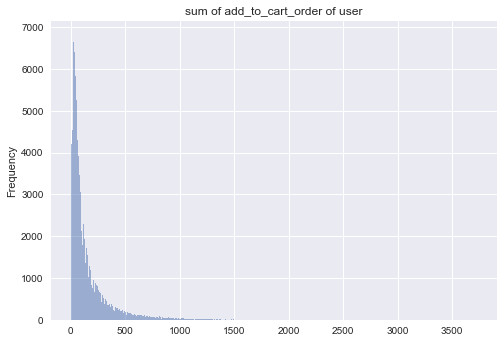

Total Order Product Number of User
Size of total user (206209, 2)
Size of <20 user (20974, 2)
Size of >500 user (13305, 2)


In [11]:
cnt_srs = order_products_prior_df.groupby(["user_id", "order_id"])["add_to_cart_order"].aggregate("max").reset_index()
cnt_srs1 = cnt_srs.groupby(["user_id"])["add_to_cart_order"].aggregate("sum").reset_index()
print("Total product number of user")
print(cnt_srs1.add_to_cart_order.describe())
cnt_srs1.add_to_cart_order.plot(kind="hist", title="sum of add_to_cart_order of user", bins=1000, alpha=0.5)
#plt.savefig('./output/2.png', dpi=300)
plt.show()

print("Total Order Product Number of User")
print("Size of total user",cnt_srs1.shape)
print("Size of <20 user",cnt_srs1[cnt_srs1.add_to_cart_order <= 20].shape)
print("Size of >500 user",cnt_srs1[cnt_srs1.add_to_cart_order >= 500].shape)

> user_id當作樞紐，每個人總購買數量的分佈。方便刪除不重要的user，跟找出重要user。  
每次的購買數量相加！

In [12]:
### merge order_product_pirior and products
order_products_prior_df = pd.merge(order_products_prior_df, products, on='product_id', how='left')
order_products_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id
0,2,33120,1,1,202279,prior,3,5,9,8.000,Organic Egg Whites,86,16
1,2,28985,2,1,202279,prior,3,5,9,8.000,Michigan Organic Kale,83,4
2,2,9327,3,0,202279,prior,3,5,9,8.000,Garlic Powder,104,13
3,2,45918,4,1,202279,prior,3,5,9,8.000,Coconut Butter,19,13
4,2,30035,5,0,202279,prior,3,5,9,8.000,Natural Sweetener,17,13


   aisle_id  department_id  reordered
0         1             20      0.597
1         2             16      0.489
2         3             19      0.598
3         4              9      0.490
4         5             13      0.281


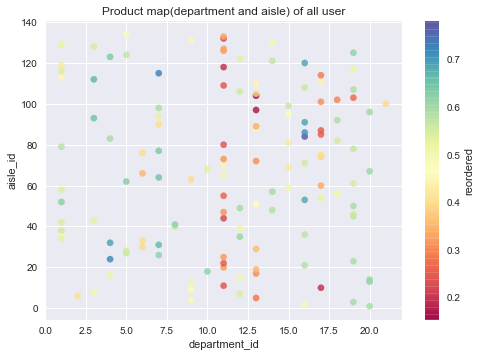

In [13]:
grouped_df = order_products_prior_df.groupby(["aisle_id", "department_id"])["reordered"].aggregate("mean").reset_index()
print(grouped_df.head())

import matplotlib.pyplot as plt
from matplotlib import cm


fig, ax = plt.subplots()
cmap = cm.get_cmap('Spectral')
grouped_df.plot(x='department_id', y='aisle_id', ax = ax,
                title="Product map(department and aisle) of all user",
                kind='scatter', s=40, c='reordered', cmap=cmap, alpha=0.8)
ax.set_xlabel("department_id")
plt.show()

> 像地圖一樣，標出每個商品的reorder比例。  
找出較常購買的區域，也找出熱門商品跟找出冷門商品。

## Focus on user_id

In [14]:
user_id = 3000
df_user = order_products_prior_df[order_products_prior_df.user_id == user_id]
df_user = df_user.sort_values(by = ['order_number', 'add_to_cart_order'], ascending = True)
orders_Unique = len(set(df_user.order_id))
print("Number of order :", orders_Unique)

#df_user = pd.merge(df_user, products, on='product_id', how='left')
df_user = pd.merge(df_user, aisles, on='aisle_id', how='left')
df_user = pd.merge(df_user, departments, on='department_id', how='left')
print("Size of user_id = " + str(user_id) + " :", df_user.shape[0])
df_user.head()

Number of order : 18
Size of user_id = 3000 : 264


,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
0,3057731,47626,1,0,3000,prior,1,3,7,nan,Large Lemon,24,4,fresh fruits,produce
1,3057731,1313,2,0,3000,prior,1,3,7,nan,Tortilla Strips Restaurant Style,107,19,chips pretzels,snacks
2,3057731,30776,3,0,3000,prior,1,3,7,nan,Organic Raw Kombucha Gingerade,31,7,refrigerated,beverages
3,3057731,49683,4,0,3000,prior,1,3,7,nan,Cucumber Kirby,83,4,fresh vegetables,produce
4,3057731,46294,5,0,3000,prior,1,3,7,nan,Organic Parsley,16,4,fresh herbs,produce


Product map(aisle_id and department_id) of user_id = 3000
    aisle_id  department_id  reorder_sum
19        83              4           40
5         24              4           22
8         31              7           14
33       123              4           13
2         16              4            9


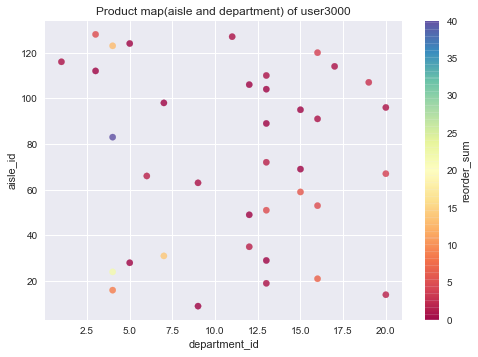

In [15]:
grouped_df = df_user.groupby(["aisle_id", "department_id"])["reordered"].aggregate({'reorder_sum': 'sum'}).reset_index()
grouped_df = grouped_df.sort_values(by = 'reorder_sum', ascending = False)
print("Product map(aisle_id and department_id) of user_id = " + str(user_id))
print(grouped_df.head())

import matplotlib.pyplot as plt
from matplotlib import cm
cmap = cm.get_cmap('Spectral')

fig, ax = plt.subplots()
grouped_df.plot(x='department_id', y='aisle_id', ax = ax,
                title="Product map(aisle and department) of user" + str(user_id),
                kind='scatter', s=40, c='reorder_sum', cmap=cmap, alpha=0.8)
plt.show()    

> 用地圖的方式呈現該消費者傾像購買的貨櫃架跟部門

Product map(product_id and aisle_id) of user_id = 3000
     product_id  aisle_id  department_id  reorder_sum  total_order
110       49683        83              4            8           18
74        36685       123              4            8           18
18        10411        83              4            6           18
102       47626        24              4            6           18
6          5450        24              4            6           18


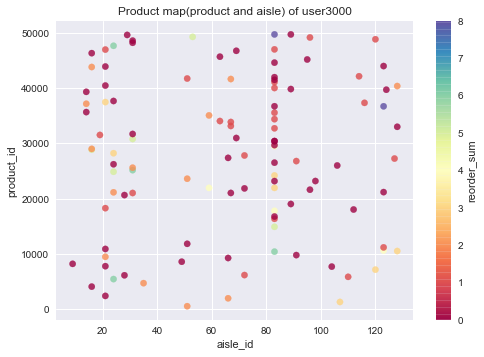

In [16]:
grouped_df = df_user.groupby(["product_id", "aisle_id", "department_id"])["reordered"].aggregate({'reorder_sum': 'sum'}).reset_index()
grouped_df = grouped_df.sort_values(by = 'reorder_sum', ascending = False)
grouped_df["total_order"] = orders_Unique
print("Product map(product_id and aisle_id) of user_id = " + str(user_id))
print(grouped_df.head())

import matplotlib.pyplot as plt
from matplotlib import cm
cmap = cm.get_cmap('Spectral')

fig, ax = plt.subplots()
grouped_df.plot(x='aisle_id', y='product_id', ax = ax,
                title="Product map(product and aisle) of user" + str(user_id),
                kind='scatter', s=40, c='reorder_sum', cmap=cmap, alpha=0.8)
plt.show()    

> 該消費者最愛購買的商品。

In [17]:
### 有reorder pixalRNN, non reorder找商品關聯性(位置或)。 看解釋～～～
grouped_df.reorder_sum.value_counts()

0    51
1    25
2    13
3     7
5     5
6     4
4     4
8     2
Name: reorder_sum, dtype: int64

In [18]:
x, y= [],[]
for i in range(0,24):
    df = df_user[df_user.order_hour_of_day == i]
    if df.shape[0] == 0:
        x.append(0)
    else:
        df1 = pd.DataFrame(df.order_number.describe())
        df1.columns = ["hr"+str(i)]
        y.append(df1)
        x.append(len(set(df.order_id)))

df_user_hour = pd.concat(y, axis = 1)
print("Hr of user_id =" + str(user_id) + " buying")
print(x)
print("======================================================================")
print("order_number and hour of day for user_id =" + str(user_id))
df_user_hour

Hr of user_id =3000 buying
[1, 0, 0, 0, 0, 0, 0, 1, 1, 2, 1, 1, 1, 0, 0, 3, 1, 5, 1, 0, 0, 0, 0, 0]
order_number and hour of day for user_id =3000


,hr0,hr7,hr8,hr9,hr10,hr11,hr12,hr15,hr16,hr17,hr18
count,32.000,13.000,17.000,37.000,19.000,6.000,17.000,16.000,27.000,72.000,8.000
mean,3.000,1.000,12.000,9.973,9.000,2.000,4.000,12.625,5.000,13.083,8.000
std,0.000,0.000,0.000,3.516,0.000,0.000,0.000,2.187,0.000,4.285,0.000
min,3.000,1.000,12.000,6.000,9.000,2.000,4.000,10.000,5.000,7.000,8.000
25%,3.000,1.000,12.000,6.000,9.000,2.000,4.000,11.000,5.000,7.000,8.000
50%,3.000,1.000,12.000,13.000,9.000,2.000,4.000,11.000,5.000,14.000,8.000
75%,3.000,1.000,12.000,13.000,9.000,2.000,4.000,15.000,5.000,17.000,8.000
max,3.000,1.000,12.000,13.000,9.000,2.000,4.000,15.000,5.000,18.000,8.000


> 看出user購買的時間以及購物物數量的分佈。

### for loop

In [19]:
user_number = 100

hr = []
for i in range(1, user_number):
    user_id = i
    df_user = order_products_prior_df[order_products_prior_df.user_id == user_id]
#    print("Size of user_id = " + str(i),df_user.shape[0])
    
#    grouped_df = df_user.groupby(["product_id", "aisle_id", "department_id"])["reordered"].aggregate("mean").reset_index()
    # plot map
#    plt.figure(figsize=(20,20))
#    grouped_df.plot(x='aisle_id', y='product_id',
#                    title="Product map(product and aisle) of user_id=" + str(i),
#                    kind='scatter', s=40, c='reordered', cmap=cmap, alpha=0.8)
#    plt.show()
    
    x, y, z = [],[],[]
    for j in range(0,24):
        df = df_user[df_user.order_hour_of_day == j]
        if df.shape[0] == 0:
            z.append(0)
        else:
            df1 = pd.DataFrame(df.order_number.describe())
            df1.columns = ["hr"+str(j)]
            y.append(df1)
            z.append(len(set(df.order_id)))
    
    hr.append(z)
    df_user_hour = pd.concat(y, axis = 1)
#    print("order_number and hour of day for user_id =" + str(user_id))
#    print(df_user_hour)

In [20]:
df_hr = pd.DataFrame(hr, columns = ["hr0","hr1","hr2","hr3","hr4","hr5","hr6",
                                    "hr7","hr8","hr9","hr10","hr11","hr12",
                                    "hr13","hr14","hr15","hr16","hr17","hr18",
                                    "hr19","hr20","hr21","hr22","hr23"])
df_hr.insert(0, 'user_id', (df_hr.index + 1))
df_hr.head()

,user_id,hr0,hr1,hr2,hr3,hr4,hr5,hr6,hr7,hr8,...,hr14,hr15,hr16,hr17,hr18,hr19,hr20,hr21,hr22,hr23
0,1,0,0,0,0,0,0,0,3,2,...,1,1,1,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,1,2,4,2,2,1,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,...,0,0,1,0,2,0,0,0,0,0


> 計算每個顧客在不同購買時間的次數  
可以藉由購買時間相同的顧客做分群

In [21]:
aisle = []
for i in range(1, user_number):
    user_id = i
    df_user = order_products_prior_df[order_products_prior_df.user_id == user_id]
    
    z = []
    for j in range(1, aisles.shape[0]+1):
        df = df_user[df_user.aisle_id == j]
        if df.shape[0] == 0:
            z.append(0)
        else:
            z.append(df.shape[0])
    aisle.append(z)

df_aisle = pd.DataFrame(aisle, columns = np.arange(1, (pd.DataFrame(aisle).shape[1]+1), 1))
df_aisle.insert(0, 'user_id', (df_aisle.index + 1))
df_aisle.iloc[:10, :]

,user_id,1,2,3,4,5,6,7,8,9,...,125,126,127,128,129,130,131,132,133,134
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1,0,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,9,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
9,10,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


> 把每個顧客在各個貨架的數量算出並列成矩陣  
可以藉由購買貨架相似的顧客做分群

In [22]:
dep = []
for i in range(1, user_number):
    user_id = i
    df_user = order_products_prior_df[order_products_prior_df.user_id == user_id]
    
    z = []
    for j in range(1, departments.shape[0]+1):
        df = df_user[df_user.department_id == j]
        if df.shape[0] == 0:
            z.append(0)
        else:
            z.append(df.shape[0])
    dep.append(z)

df_dep = pd.DataFrame(dep, columns = np.arange(1, (pd.DataFrame(dep).shape[1]+1), 1))
df_dep.insert(0, 'user_id', (df_aisle.index + 1))
df_dep.iloc[:10, :]

,user_id,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,1,0,0,0,5,0,0,13,0,0,...,0,1,3,0,13,2,0,22,0,0
1,2,17,0,2,36,0,3,9,0,0,...,1,11,3,1,48,0,0,42,21,0
2,3,6,0,0,38,0,0,3,0,4,...,0,4,0,0,21,1,0,9,2,0
3,4,3,0,2,2,2,0,3,0,0,...,0,0,0,1,0,2,0,1,2,0
4,5,2,0,0,19,0,2,0,0,1,...,0,2,0,1,8,0,0,1,1,0
5,6,0,0,0,6,0,0,0,0,0,...,2,1,0,3,2,0,0,0,0,0
6,7,4,0,5,57,0,0,51,1,0,...,8,9,0,6,32,1,0,19,13,0
7,8,0,0,0,27,0,1,0,0,1,...,0,3,0,5,12,0,0,0,0,0
8,9,1,0,4,7,0,0,8,0,0,...,1,4,3,1,24,1,6,13,3,0
9,10,1,0,0,72,0,1,0,0,0,...,13,22,0,2,16,0,0,1,15,0


> 把每個顧客在各個部門的數量算出並列成矩陣  
可以藉由購買部門相似的顧客做分群

In [23]:
order_products_prior_df["add_to_cart_order_mod"] = order_products_prior_df["add_to_cart_order"].copy()
order_products_prior_df["add_to_cart_order_mod"].ix[order_products_prior_df["add_to_cart_order_mod"] > 70] = 70

add_to = []
for i in range(1, user_number):
    user_id = i
    df_user = order_products_prior_df[order_products_prior_df.user_id == user_id]

    z = []
    for j in range(1, max(df_user.add_to_cart_order_mod) + 1):
        df = df_user[df_user.add_to_cart_order == j]
        df0 = df_user[df_user.add_to_cart_order == j+1]
        z.append((df.shape[0] - df0.shape[0]))
    add_to.append(z)


In [24]:
df_add_to = pd.DataFrame(add_to, columns = np.arange(1, (pd.DataFrame(add_to).shape[1]+1), 1))
df_add_to.insert(0, 'user_id', (df_add_to.index + 1))
df_add_to.iloc[:10, :]

,user_id,1,2,3,4,5,6,7,8,9,...,37,38,39,40,41,42,43,44,45,46
0,1,0,0,0,1.000,4.000,3.000,0.000,1.000,1.000,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,2,0,0,0,0.000,1.000,1.000,0.000,0.000,2.000,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,3,0,0,0,0.000,3.000,3.000,0.000,2.000,2.000,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,4,0,2,1,1.000,0.000,0.000,1.000,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,5,0,0,0,0.000,1.000,0.000,0.000,0.000,1.000,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
5,6,0,0,1,1.000,0.000,0.000,1.000,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
6,7,1,0,1,2.000,1.000,0.000,1.000,1.000,2.000,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
7,8,0,0,0,0.000,0.000,0.000,0.000,0.000,0.000,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
8,9,0,0,0,0.000,0.000,0.000,0.000,0.000,0.000,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
9,10,0,0,0,0.000,1.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000


> 放入購物籃的最大數量的矩陣  
因為上次的視覺化發現一天時間，購買數量，商品貨櫃都與重複購買有相關，  
所以想用這幾個變數對顧客分類，再去建模。

In [25]:
del df_hr["user_id"]
del df_aisle["user_id"]
del df_dep["user_id"]
del df_add_to["user_id"]

0    53
8    25
4     7
5     6
9     2
1     2
7     1
6     1
3     1
2     1
Name: label, dtype: int64


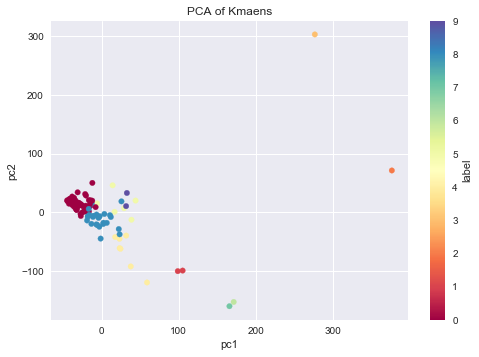

In [26]:
n_clusters = 10

### merge hour, aisle, department, add_to_basket_order
df = pd.concat([df_hr, df_aisle, df_dep, df_add_to], ignore_index = True, axis = 1)
df = df.fillna(0)
#print(df.shape[1])

### kmeans 對顧客分群
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = n_clusters, random_state = 0).fit(df)
label_kmeans = pd.DataFrame(kmeans.labels_)
df = pd.concat([df, label_kmeans], ignore_index = True, axis = 1)
#print(df.shape[1])

### 降維看結果
from sklearn.decomposition import PCA
X = df.iloc[:, :(df.shape[1]-1)]
pca = PCA(n_components = 2)
X_pca = pd.DataFrame(pca.fit_transform(X))
df_pca = pd.concat([X_pca, df.iloc[:, [df.shape[1]-1]]], ignore_index = True, axis = 1)
df_pca.columns = ["pc1", "pc2", "label"]
#print(df_pca.shape[1])
print(df_pca.label.value_counts())

### plot PCA of Kmeans label
fig, ax = plt.subplots()
df_pca.plot(x='pc1', y='pc2', ax = ax, title="PCA of Kmaens",
            kind='scatter', s=30, c='label', cmap=cmap, alpha=1)
plt.show()